In [1]:
import copy
from pathlib import Path
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import trange

from kgi import apply_kgi_to_model

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

In [3]:
def default_init_to_he_uniform(model):
    """ Change PyTorch's default initialization to He uniform """
    # PyTorch default uses 1/sqrt(m) as the bound
    # He uniform uses sqrt(3)/sqrt(m) as the bound
    sqrt3 = np.sqrt(3)
    for layer in model.modules():
        if isinstance(layer, torch.nn.Linear):
            layer.weight.data *= sqrt3
            layer.bias.data *= sqrt3


class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)
        self.act = activation
        default_init_to_he_uniform(self)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        return x

# Visualize initialized models

In [4]:
def find_knots(y, dx, threshold=1e-11):
    """ Find indices of knots in a curve """
    if len(y) < 2:
        return []
    # calculate the slopes between consecutive points
    slopes = (y[1:] - y[:-1]) / dx
    # find where the slopes change
    slope_changes = torch.abs(torch.diff(slopes))
    knots = torch.where(slope_changes > threshold)[0] + 1  # noqa
    return knots.tolist()

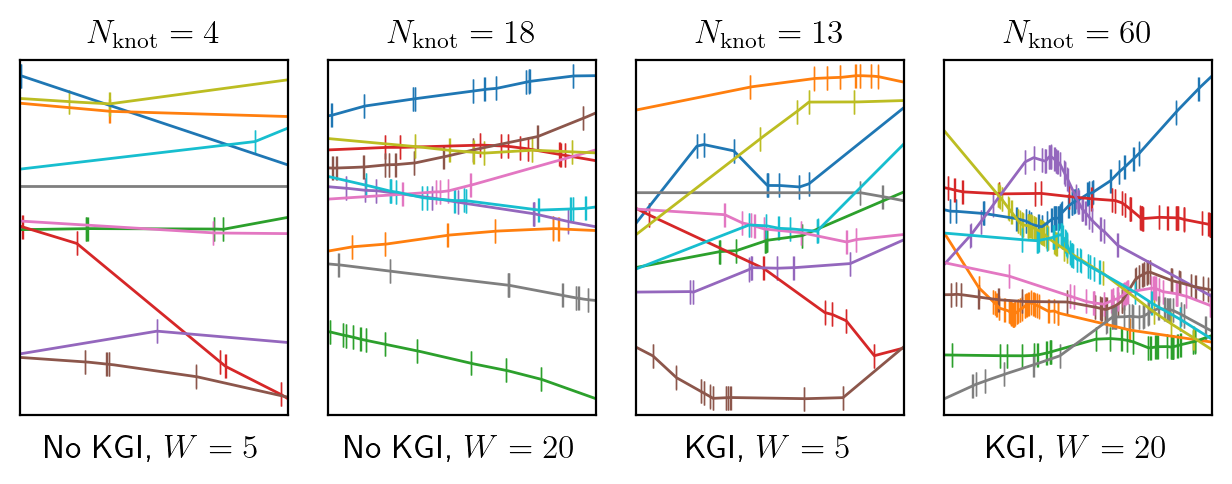

In [5]:
# use double for more accurate knot finding
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)

# set number of curves
n_curve = 10

# hidden sizes to consider
n_hidden = [5, 20]

# input
x_in = torch.linspace(0, 1, 1000).unsqueeze(1)

fig, axes = plt.subplots(1, 2 * len(n_hidden), figsize=(10 / 1.3, 3 / 1.3), dpi=200)
plt.subplots_adjust(wspace=.15)
for i_n, n in enumerate(n_hidden):
    n_knots_def = 0
    n_knots_kgi = 0
    for i in range(n_curve):
        # default model
        model_def = MLP(1, hidden_size=n)
        model_def.eval()

        # KGI model
        model_kgi = copy.deepcopy(model_def)
        apply_kgi_to_model(model_kgi, knot_low=0.2, knot_high=0.8,
                           perturb_factor=0.2, kgi_by_bias=False)

        # forward
        with torch.no_grad():
            y_def = model_def(x_in).squeeze(1)
            y_kgi = model_kgi(x_in).squeeze(1)

        # find knots
        knots_def = find_knots(y_def, x_in[1] - x_in[0])
        knots_kgi = find_knots(y_kgi, x_in[1] - x_in[0])
        n_knots_def += len(knots_def)
        n_knots_kgi += len(knots_kgi)

        # plot
        axes[i_n + 0].plot(x_in, y_def, lw=1)
        axes[i_n + 0].scatter(x_in[knots_def], y_def[knots_def], marker="|", s=80, lw=.5)
        axes[i_n + 2].plot(x_in, y_kgi, lw=1)
        axes[i_n + 2].scatter(x_in[knots_kgi], y_kgi[knots_kgi], marker="|", s=80, lw=.5)

    # title
    axes[i_n + 0].text(x=0.5, y=-0.12,
                       s="No KGI, $W=%d$" % (n,),
                       fontsize=12, ha='center',
                       transform=axes[i_n + 0].transAxes)
    axes[i_n + 0].text(x=0.5, y=1.03,
                       s="$N_\\mathrm{knot}=%d$" % (round(n_knots_def / n_curve),),
                       fontsize=12, ha='center', va='bottom',
                       transform=axes[i_n + 0].transAxes)
    axes[i_n + 2].text(x=0.5, y=-0.12,
                       s="KGI, $W=%d$" % (n,),
                       fontsize=12, ha='center',
                       transform=axes[i_n + 2].transAxes)
    axes[i_n + 2].text(x=0.5, y=1.03,
                       s="$N_\\mathrm{knot}=%d$" % (round(n_knots_kgi / n_curve),),
                       fontsize=12, ha='center', va='bottom',
                       transform=axes[i_n + 2].transAxes)

# setup
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 1)
plt.savefig("figs/curve_knots.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

# Curve fitting

## Target

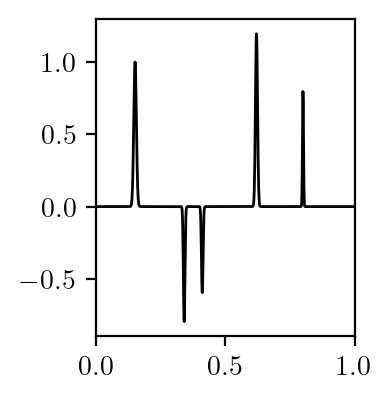

In [6]:
torch.set_default_dtype(torch.float32)


def gaussian(x, mu, sigma, height):
    """ Gaussian shape """
    exponent = -((x - mu) ** 2) / (2 * sigma ** 2)
    return height * torch.exp(exponent)


# ground truth
x_in = torch.linspace(0, 1, 1000)
y_true = torch.zeros_like(x_in)
y_true += gaussian(x_in, 0.15, 0.005, 1)
y_true -= gaussian(x_in, 0.34, 0.003, .8)
y_true -= gaussian(x_in, 0.41, 0.003, .6)
y_true += gaussian(x_in, 0.62, 0.004, 1.2)
y_true += gaussian(x_in, 0.8, 0.002, 0.8)
plt.figure(figsize=(3 / 1.8, 3.7 / 1.8), dpi=200)
plt.plot(x_in, y_true, lw=1, c="k")
plt.xlim(0, 1)
plt.savefig("figs/curve_target.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

## Training

In [7]:
def train(kgi, hidden_size, num_hidden_layers, seed, activation=torch.relu,
          num_epochs=10000, log_loss_every=20, device="cpu", pbar=True):
    """ Train a model """
    torch.manual_seed(seed)
    model = MLP(1, hidden_size=hidden_size, num_hidden_layers=num_hidden_layers,
                activation=activation)
    if kgi:
        if activation is torch.nn.functional.tanh:
            apply_kgi_to_model(model,
                               knot_low=[0.2] + [-0.8] * (num_hidden_layers + 1),
                               knot_high=[0.8] * (num_hidden_layers + 2),
                               perturb_factor=0.2, kgi_by_bias=False)
        elif activation is torch.nn.functional.gelu:
            apply_kgi_to_model(model, knot_low=0.0, knot_high=1.0,
                               perturb_factor=0.2, kgi_by_bias=False)
        else:
            apply_kgi_to_model(model, knot_low=0.2, knot_high=0.8,
                               perturb_factor=0.2, kgi_by_bias=False)
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # training loop
    loss_hist = []
    x_in_ = x_in.unsqueeze(1).to(device)
    y_true_ = y_true.unsqueeze(1).to(device)
    for epoch in trange(num_epochs, disable=not pbar):
        y_pred = model(x_in_)
        loss = criterion(y_pred, y_true_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (epoch + 1) % log_loss_every == 0:
            loss_hist.append(loss.item())
    return model, loss_hist

In [8]:
# train all models
reproduce_paper = False
if reproduce_paper:
    """ THIS WILL TAKE A LONG TIME TO TRAIN THE 10x10x4x2 MODELS """
    seeds = list(range(10))
    nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
                (25, 2), (25, 3), (25, 4), (25, 5)]
    activations = [torch.nn.functional.relu, torch.nn.functional.leaky_relu,
                   torch.nn.functional.gelu, torch.nn.functional.tanh]
    epochs = 30000
    device_ = "cuda"
    out_dir = Path("results/curve_paper")
    show_pbar = False
else:
    seeds = [0]
    nn_sizes = [(200, 1)]
    activations = [torch.nn.functional.relu]
    epochs = 10000
    device_ = "cpu"
    out_dir = Path("results/curve_test")
    show_pbar = True

out_dir.mkdir(exist_ok=True, parents=True)
for seed_ in seeds:
    for act_ in activations:
        for hidden_size_, num_hidden_layers_ in nn_sizes:
            for kgi_ in [False, True]:
                act_name_ = "gelu" if act_ is torch.nn.functional.gelu else str(act_).split(" ")[1]
                name_ = f"{act_name_}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{kgi_}"
                if not (out_dir / name_).exists():
                    t0 = time()
                    _, hist_ = train(kgi_, hidden_size_, num_hidden_layers_, seed_, act_, device=device_,
                                     num_epochs=epochs, pbar=show_pbar)
                    np.savetxt(out_dir / name_, hist_)
                    print(f"{name_} trained in {(time() - t0) / 60:.1f} min, loss={hist_[-1]:.2e}")
                else:
                    print(f"{name_} exists")

relu_0_200_1_False exists
relu_0_200_1_True exists


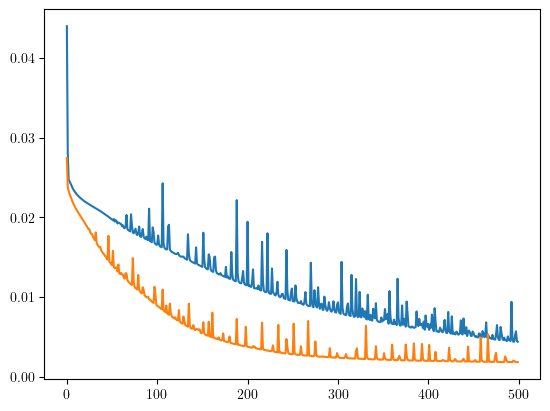

In [9]:
# quick comparison
hist_def = np.loadtxt(out_dir / "relu_0_200_1_False")
hist_kgi = np.loadtxt(out_dir / "relu_0_200_1_True")
plt.plot(hist_def)
plt.plot(hist_kgi)
plt.show()

## Analysis

The following cells works only when `reproduce_paper` was set `True` for training.

In [10]:
seeds = list(range(10))
nn_sizes = [(25, 1), (50, 1), (100, 1), (200, 1), (400, 1), (600, 1),
            (25, 2), (25, 3), (25, 4), (25, 5)]
epochs = 30000
out_dir = Path("results/curve_paper")

### Loss statistics

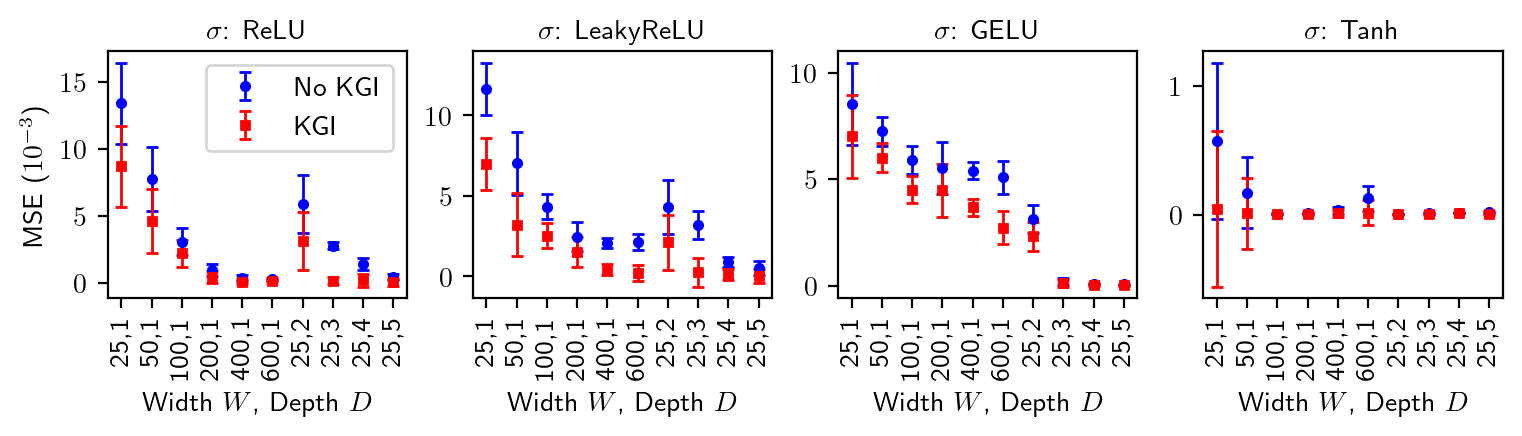

In [11]:
def get_metrics(act_name, kgi):
    min_loss_mean = []
    min_loss_std = []
    for hidden_size, num_hidden_layers in nn_sizes:
        hists = []
        for seed in seeds:
            name = f"{act_name}_{seed}_{hidden_size}_{num_hidden_layers}_{kgi}"
            hist = np.loadtxt(out_dir / name)
            hists.append(hist)
        hists = np.array(hists) * 1000
        min_loss = np.mean(hists[:, -5:], axis=1)
        min_loss = np.sort(min_loss)
        min_loss_mean.append(min_loss[:-4].mean())
        min_loss_std.append(min_loss[:-4].std())
    return np.array(min_loss_mean), np.array(min_loss_std)


fig, axes = plt.subplots(1, 4, figsize=(9, 1.6), dpi=200, sharex=True)
plt.subplots_adjust(wspace=.22)
for i, (act, act_str) in enumerate(zip(["relu", "leaky_relu", "gelu", "tanh"],
                                       ["ReLU", "LeakyReLU", "GELU", "Tanh"])):
    min_mean_def, min_std_def = get_metrics(act, False)
    min_mean_kgi, min_std_kgi = get_metrics(act, True)
    x_fake = range(len(min_mean_def))
    axes[i].errorbar(x_fake, min_mean_def, min_std_def, fmt="o",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="No KGI", c="b")
    axes[i].errorbar(x_fake, min_mean_kgi, min_std_def, fmt="s",
                     markersize=3, capsize=2, capthick=1, elinewidth=1, label="KGI", c="r")
    axes[i].set_xticks(x_fake, ["25,1", "50,1", "100,1", "200,1", "400,1", "600,1",
                                "25,2", "25,3", "25,4", "25,5"])
    for label in axes[i].get_xticklabels():
        label.set_rotation(90)
    axes[i].set_xlabel("Width $W$, Depth $D$")
    axes[i].text(.5, 1.03, f"$\sigma$: {act_str}", va="bottom", ha="center",
                 transform=axes[i].transAxes)

axes[0].set_ylabel("MSE ($10^{-3}$)")
axes[0].legend()
axes[1].set_yticks([0, 5, 10])
axes[2].set_yticks([0, 5, 10])
axes[3].set_yticks([0, 1])
plt.savefig("figs/curve_loss_WD.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()

### Loss history

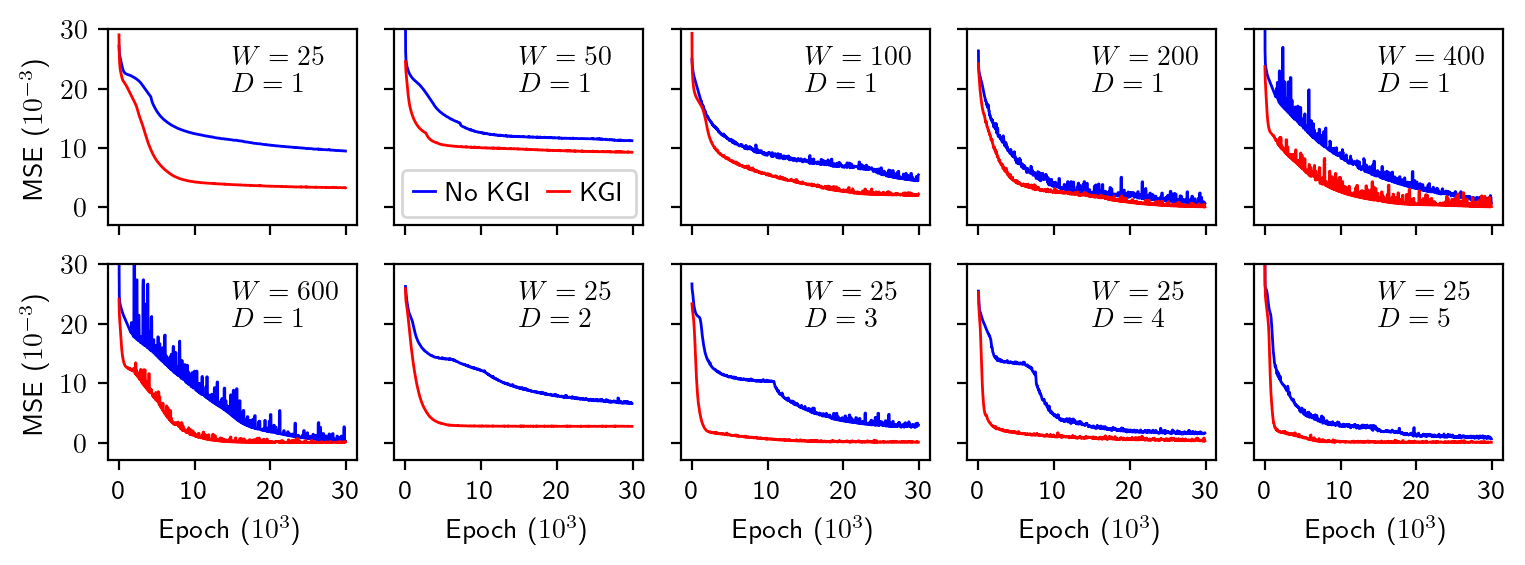

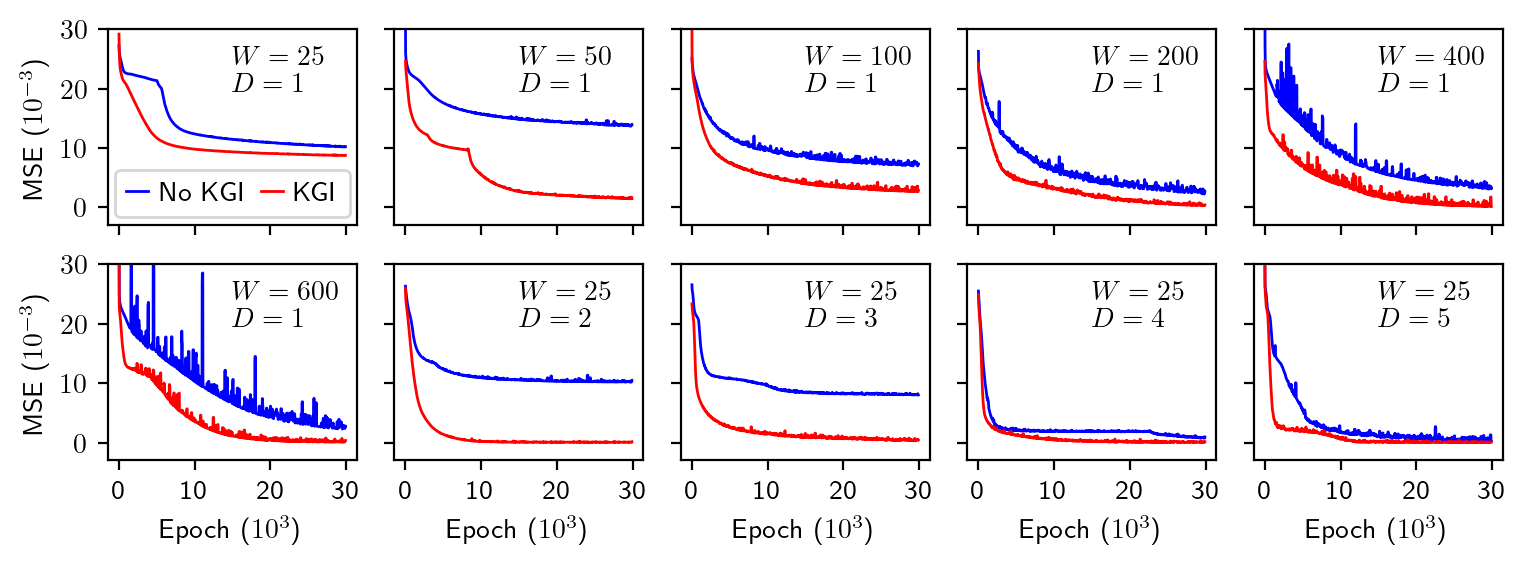

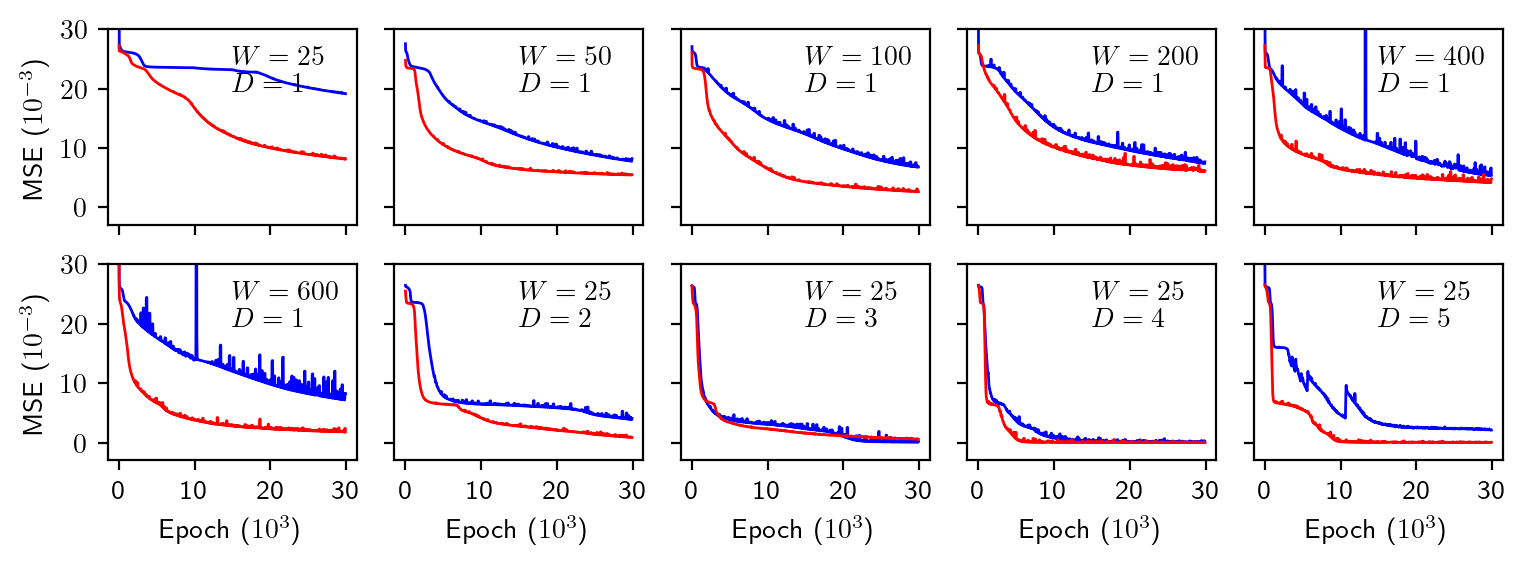

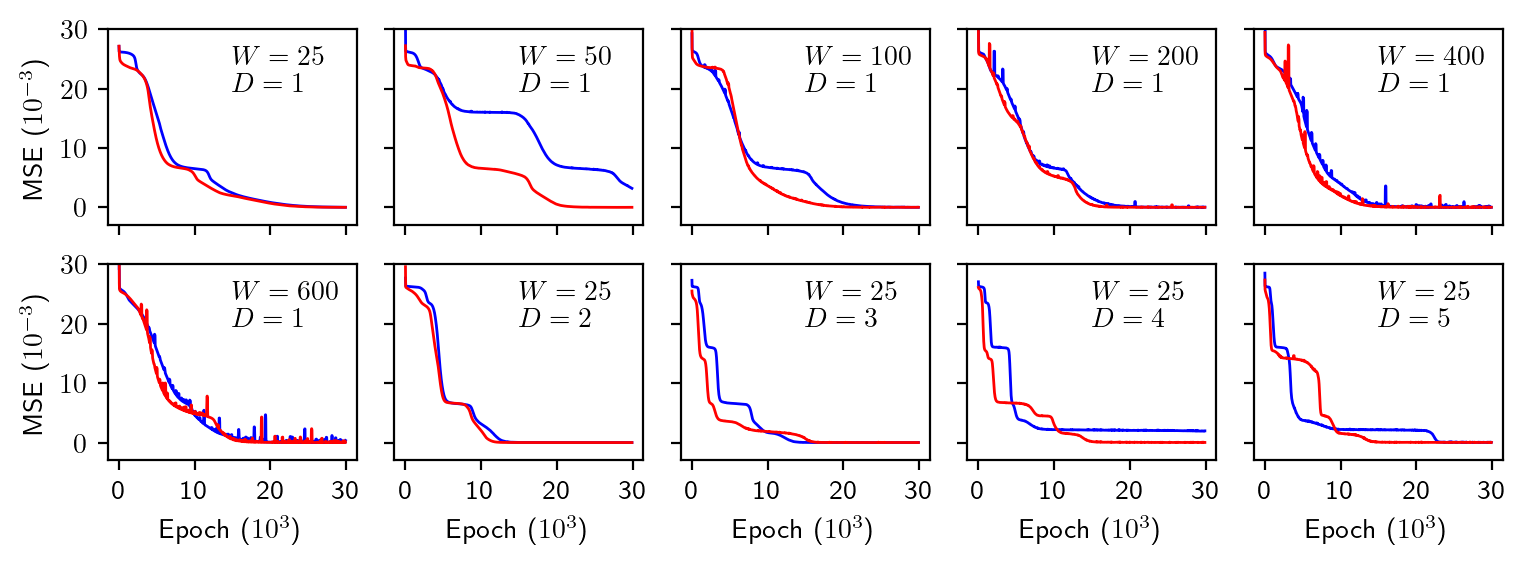

In [12]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


for act in ["relu", "leaky_relu", "gelu", "tanh"]:
    _, axes = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(9, 2.8), dpi=200)
    plt.subplots_adjust(wspace=.15)
    for i, (hidden_size_, num_hidden_layers_) in enumerate(nn_sizes):
        seed_ = 0
        hist_def = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{False}")
        hist_kgi = np.loadtxt(out_dir / f"{act}_{seed_}_{hidden_size_}_{num_hidden_layers_}_{True}")
        ax = axes[i // 5, i % 5]
        p = 5
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_def, p) * 1000, label="No KGI", lw=1, c='b')
        ax.plot(np.arange(epochs // 20 - p // 2 - 2), moving_ave(hist_kgi, p) * 1000, label="KGI", lw=1, c='r')
        ax.text(.5, .92, f"$W={hidden_size_}$", va="top", ha="left", transform=ax.transAxes)
        ax.text(.5, .78, f"$D={num_hidden_layers_}$", va="top", ha="left", transform=ax.transAxes)
    
    axes[0, 0].set_ylim(-3, 30)
    for i in range(2):
        axes[i, 0].set_ylabel("MSE ($10^{-3}$)")
        axes[i, 0].set_yticks([0, 10, 20, 30])
    for i in range(5):
        axes[1, i].set_xlabel("Epoch ($10^3$)")
        axes[1, i].set_xticks([0, 10000 // 20, 20000 // 20, 30000 // 20], [0, 10, 20, 30])
    if act == "relu":
        axes[0, 1].legend(ncol=2, loc=[0.03, 0.04], handlelength=.8, columnspacing=.5, handletextpad=.4)
    elif act == "leaky_relu":
        axes[0, 0].legend(ncol=2, loc=[0.03, 0.04], handlelength=.8, columnspacing=.5, handletextpad=.4)
    plt.savefig(f"figs/curve_loss_epoch_{act}.pdf", bbox_inches='tight', pad_inches=0.01)
    plt.show()

## Animate training

Now we zoom into the convergence process. Make sure you have `ffmpeg` installed.

In [13]:
def train_animate(kgi, hidden_size, num_hidden_layers, seed, activation=torch.relu,
                  num_epochs=20000, plot_every=20, device="cpu", pbar=True):
    """ Animate training """
    torch.manual_seed(seed)
    model = MLP(1, hidden_size, num_hidden_layers, activation)
    if kgi:
        if activation is torch.nn.functional.tanh:
            apply_kgi_to_model(model,
                               knot_low=[0.2] + [-0.8] * (1 + 1),
                               knot_high=[0.8] * (1 + 2),
                               perturb_factor=0.2, kgi_by_bias=False)
        elif activation is torch.nn.functional.gelu:
            apply_kgi_to_model(model, knot_low=0.0, knot_high=1.0,
                               perturb_factor=0.2, kgi_by_bias=False)
        else:
            apply_kgi_to_model(model, knot_low=0.2, knot_high=0.8,
                               perturb_factor=0.2, kgi_by_bias=False)
    model.to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # output
    out = Path("results/curve_animation")
    out.mkdir(exist_ok=True, parents=True)

    # training loop
    x_in_ = x_in.unsqueeze(1).to(device)
    y_true_ = y_true.unsqueeze(1).to(device)
    for epoch in trange(num_epochs, disable=not pbar):
        y_pred = model(x_in_)
        loss = criterion(y_pred, y_true_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # plot a snapshot
        if (epoch + 1) % plot_every == 0 or epoch == 0:
            plt.figure(dpi=200)
            plt.plot(x_in, y_true, c='gray', lw=0.5)
            y_pred = y_pred.squeeze(1).detach().cpu()
            knots = find_knots(y_pred, x_in[1] - x_in[0], threshold=1e-3)
            plt.plot(x_in, y_pred, c='b', lw=1)
            plt.scatter(x_in[knots], y_pred[knots], marker="|", s=200, lw=1, c='r')
            plt.gca().axis("off")
            plt.text(0.6, 0.24, "KGI" if kgi else "No KGI", transform=plt.gca().transAxes, fontsize=16)
            plt.text(0.6, 0.17, f"Epoch = {epoch + 1}", transform=plt.gca().transAxes, fontsize=16)
            plt.text(0.6, 0.1, f"Loss = {loss.item():.1e}", transform=plt.gca().transAxes, fontsize=16)
            plt.savefig(out / f"{'KGI' if kgi else 'No_KGI'}_{(epoch + 1) // plot_every + 1}.png",
                        bbox_inches='tight', pad_inches=0.01)
            plt.close()

In [14]:
# change to `True` to generate animations in ./figs/
make_animations = False

if make_animations:
    train_animate(kgi=False, hidden_size=25, num_hidden_layers=1, seed=3)
    ffmpeg_command = (f"ffmpeg -i results/curve_animation/No_KGI_%d.png -c:v libx264 " +  # noqa
                      "-framerate 10 -vf \'scale=trunc(iw/2)*2:trunc(ih/2)*2\' " +
                      "-pix_fmt yuv420p -y figs/No_KGI.mp4")
    !{ffmpeg_command}

    train_animate(kgi=True, hidden_size=25, num_hidden_layers=1, seed=3)
    ffmpeg_command = (f"ffmpeg -i results/curve_animation/KGI_%d.png -c:v libx264 " +  # noqa
                      "-framerate 30 -vf \'scale=trunc(iw/2)*2:trunc(ih/2)*2\' " +
                      "-pix_fmt yuv420p -y figs/KGI.mp4")
    !{ffmpeg_command}